In [79]:
import pandas as pd
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
df_train = pd.read_csv("/content/Disease_train.csv")
df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,patient_id,diagnosis
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,1,0
1,0.020584,0.969910,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,2,0
2,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450,3,0
3,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.140924,0.802197,0.074551,0.986887,7,0
4,0.772245,0.198716,0.005522,0.815461,0.706857,0.729007,0.771270,0.074045,0.358466,0.115869,8,0


In [81]:
scaler=StandardScaler()
df_train.iloc[:, 0:-1] = scaler.fit_transform(df_train.iloc[:, 0:-1])

In [82]:
X = df_train.drop(columns=['patient_id', 'diagnosis'])
y = df_train['diagnosis']


In [83]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [84]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [85]:
xgb_model = XGBClassifier(random_state=42)

In [86]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.6, 0.8, 1.0],
}


In [87]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

In [88]:
train_probs = best_xgb_model.predict_proba(X_train)[:,1]
train_roc_auc = roc_auc_score(y_train, train_probs)
print(f"Training ROC-AUC Score: {train_roc_auc}")

Training ROC-AUC Score: 1.0


In [89]:
val_probs = best_xgb_model.predict_proba(X_val)[:,1]
val_roc_auc = roc_auc_score(y_val, val_probs)
print(f"Validation ROC-AUC Score: {val_roc_auc}")

Validation ROC-AUC Score: 0.993602097061627


In [90]:
val_pred = (best_xgb_model.predict_proba(X_resampled)[:, 1]>0.5).astype(int)

In [91]:
accuracy = accuracy_score(y_resampled, val_pred)
report=classification_report(y_resampled,val_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9896161934805467
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3804
           1       0.98      1.00      0.99      3804

    accuracy                           0.99      7608
   macro avg       0.99      0.99      0.99      7608
weighted avg       0.99      0.99      0.99      7608



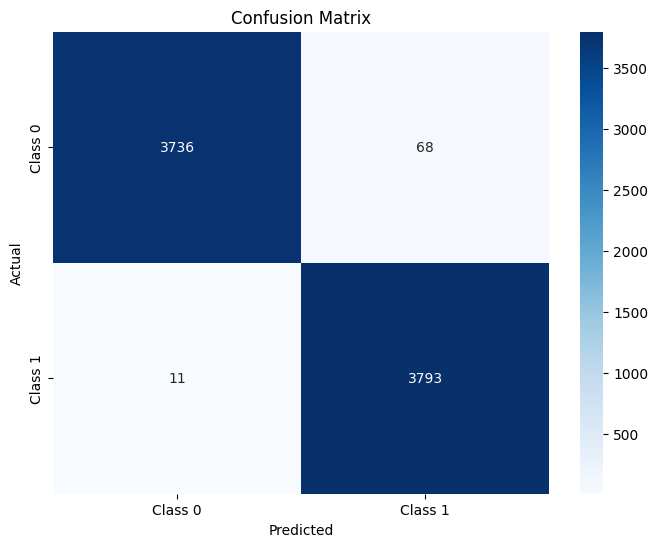

In [92]:
conf_matrix = confusion_matrix(y_resampled, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [113]:
df_test = pd.read_csv("/content/Disease_test.csv")
ID=df_test['patient_id']
df_test.iloc[:,:] = scaler.transform(df_test.iloc[:,:])

In [114]:
X_test = df_test.drop(columns=['patient_id'])
test_predictions = (best_xgb_model.predict_proba(X_test)[:, 1]>0.5).astype(int)

In [115]:
student_id = 'SE22UCSE092'
predictions_df = pd.DataFrame({
    'patient_id': ID,
    'prediction': test_predictions
})
predictions_df.to_csv(f'{student_id}_predictions.csv',index=False)
